### 06/25/23
### Joshua Edelstein
# Pneumonia Analysis
## Overview


## Business Understanding 

<div>
<img src="images/xray.jpg", width = 800, height = 400/>
</div>

Photo by <a href="https://unsplash.com/@nci?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">National Cancer Institute</a> on <a href="https://unsplash.com/s/photos/x-ray?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

## Inspect and Prepare Data

### Look at some Images



In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras import optimizers, regularizers, initializers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os

In [2]:
# Set the random seed
np.random.seed(42)

#rename the data path
train_data_dir = 'data/train'
test_data_dir = 'data/test'
val_data_dir ='data/val'

# Get all the data in the directory data/train (5216 images), and reshape them
print('Train Images:')
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5216)

print('Test Images:')
# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=624)
print('Val Images:')
# Get all the data in the directory data/train (16 images), and reshape them
val_generator = ImageDataGenerator().flow_from_directory(
        val_data_dir, 
        target_size=(64, 64), batch_size=16)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Train Images:
Found 5216 images belonging to 2 classes.
Test Images:
Found 624 images belonging to 2 classes.
Val Images:
Found 16 images belonging to 2 classes.


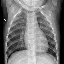

In [3]:
#Print an image
array_to_img(train_images[10])

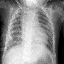

In [4]:
#Preview another image
array_to_img(train_images[3942])

### The Shape of the Data
Now, let's use np.shape() to look at what these numpy arrays look like.

In [5]:
#Use np.shape() to print the shape of the image array and label array
print('Train Images:', np.shape(train_images))
print('Train Labels:',np.shape(train_labels))
print('Test Images:',np.shape(test_images))
print('Test Labels:',np.shape(test_labels))
print('Val Images:',np.shape(val_images))
print('Val Labels:',np.shape(val_labels))

Train Images: (5216, 64, 64, 3)
Train Labels: (5216, 2)
Test Images: (624, 64, 64, 3)
Test Labels: (624, 2)
Val Images: (16, 64, 64, 3)
Val Labels: (16, 2)


### `train_images`, `test_images`, and `val_images`

We need to reshape out data to make it usable in neural network. Right now our data is arranged as `(5216, 64, 64, 3)`. The first number represents the number of images we have, for our train set, that number is 5216. The next 3 numbers represent the number of elements in the feature vector for each image. In other words, it's the number of rows when unrowing the 3 (RGB) 64 x 64 matrices.

So we need to transform this so that the data is arranged as (5216, 64x64x3)

In [6]:
# Reshape the train, test and val images 
train_img_unrow = train_images.reshape(-1, 64*64*3)
test_img_unrow = test_images.reshape(-1, 64*64*3)
val_img_unrow = val_images.reshape(-1, 64*64*3)

Verify that the shape of the the newly created `train_img_unrow` is correct.

In [7]:
# Preview the shape of train_img_unrow
np.shape(train_img_unrow)

(5216, 12288)

### `train_labels`,  `test_labels`, and `val_labels`

Earlier, you noticed that `train_labels`, `test_labels` and `val_labels` have shapes of (5216, 2), (624, 2), and (16, 2)

Let's have a closer look.

In [8]:
train_labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

Looking at this, it's clear that for each observation (or image), train_labels doesn't simply have an output of 1 or 0, but a pair - either `[0, 1]` or `[1, 0]`

Having this information, we still don't know which pair corresponds with `Normal`(healthy) vs `Pneumonia`. However, we already stored this information using keras.preprocessing_image. Let's pull it up

In [9]:
#use class indices within train_generator to pull up the key for the data
train_generator.class_indices

{'NORMAL_train': 0, 'PNEUMONIA_train': 1}

Index 0 (the first column) represents `Normal`, index 1 represents `Pneumonia`. Let's transpose all the columns so that value 1 represents `Pneumonia`.

In [103]:
#create new datasets that are transposed versions of the label dataset
train_labels_final = train_labels.T[[1]]
test_labels_final = test_labels.T[[1]]
val_labels_final = val_labels.T[[1]]

In [105]:
train_labels_final = train_labels_final.T
test_labels_final = test_labels_final.T
val_labels_final = val_labels_final.T

In [106]:
print(np.shape(train_labels_final))
print(np.shape(test_labels_final))
print(np.shape(val_labels_final))

(5216, 1)
(624, 1)
(16, 1)


Although we are not able to read xrays let's pull up an image of an xray with `Pneumonia` to see what it looks like

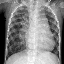

In [12]:
#use to array_to_image to pull up the 34th picture in the train set
array_to_img(train_images[34])

As we are not professionals, there doesn't seem to be anthing that stands out here

In [13]:
#pull up the label using our new label list
train_labels_final[:,34]

array([1.], dtype=float32)

Now, we are ready to move on to creating our neural network

## Build a Neural Network

For our models we will set a random seed so that the results are reproducible, additionally we will use a sequential model, where one layer builds of the previous layer. 

In [107]:
# Create the baseline model
baseline_model = Sequential()

### Add layers
Now that we have initialized a network we will add layers to the network, which include the number of layers, as well as the activation function.

The Dense() class indicates that this layer will be fully connected. 

For our `baseline_model` we'll use one hidden layers with 64 unitswith a 'relu' activation function. Also, since this is the first hidden layer, we'll pass in input_shape=(12288,). Since we are dealing with a multiclass problem (classifying the xrays into 2), we'll use a 'softmax' classifier in order to output 2 class probabilities per case

In [108]:
#add the hidden layer to the NN with 64 units, and an activation of 'relu'
baseline_model.add(Dense(64, activation='relu', input_shape=(12288,)))

#add the output layer with 2 units and an activation of softmax
baseline_model.add(Dense(1, activation='sigmoid'))  # Output layer with 2 unit for binary classification

Now, let's move on to compiling our model. We'll use `'SGD'` as our optimizer for our baseline model. For our loss we'll use binary crossentropy since this is a binary classification problem. 

In [109]:
# Compile the model #(optimizers.RMSprop(lr=0.001)) adam, AdamW
baseline_model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

Before we run our model lets pull up some summary statistics

In [110]:
#pull up summary statistics
baseline_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 64)                786496    
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 786,561
Trainable params: 786,561
Non-trainable params: 0
_________________________________________________________________


We see that our model has 786,626 trainable parameters, and this is only our baseline model. 
Now let's move on to actually fitting and running our model.

We'll start out with only 10 epochs and a batch size of 64. We'll also use our test set to test our model

In [111]:
# Train the model
results_baseline = baseline_model.fit(train_img_unrow, train_labels_final, epochs=10, batch_size=64,
                    validation_data=(test_img_unrow, test_labels_final))

Epoch 1/10


2023-06-27 10:16:37.857655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - ETA: 0s - loss: 36264.2969 - accuracy: 0.7314

2023-06-27 10:16:38.946762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 14ms/step - loss: 36264.2969 - accuracy: 0.7314 - val_loss: 0.6750 - val_accuracy: 0.6250
Epoch 2/10
82/82 [==============================] - 1s 9ms/step - loss: 0.6407 - accuracy: 0.7429 - val_loss: 0.6656 - val_accuracy: 0.6250
Epoch 3/10
82/82 [==============================] - 1s 9ms/step - loss: 0.6185 - accuracy: 0.7429 - val_loss: 0.6619 - val_accuracy: 0.6250
Epoch 4/10
82/82 [==============================] - 1s 9ms/step - loss: 0.6036 - accuracy: 0.7429 - val_loss: 0.6615 - val_accuracy: 0.6250
Epoch 5/10
82/82 [==============================] - 1s 9ms/step - loss: 0.5934 - accuracy: 0.7429 - val_loss: 0.6629 - val_accuracy: 0.6250
Epoch 6/10
82/82 [==============================] - 1s 9ms/step - loss: 0.5864 - accuracy: 0.7429 - val_loss: 0.6653 - val_accuracy: 0.6250
Epoch 7/10
82/82 [==============================] - 1s 9ms/step - loss: 0.5815 - accuracy: 0.7429 - val_loss: 0.6681 - val_accuracy: 0.6250
Epoch 8/10
82/82 [========

Now, let's create a function that takes in our results and plots how they did in terms of accuracy and loss on both the training set as well as the validation set

In [19]:
#name function visualize_training_results
def visualize_training_results(results):
    #set the history
    history = results.history
    
    #create figure for loss
    plt.figure(figsize=(5,5))
    
    #plot the validation set loss followed by the training set loss
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    
    #ad a legend
    plt.legend(['val_loss', 'loss'])
    
    #label the graph and axes
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    #create a figure for accuracy
    plt.figure(figsize=(5,5))
    
    #plot the accuracy for both the validation and training set
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    
    #create a legend
    plt.legend(['val_accuracy', 'accuracy'])
    
    #Label the graph and it's axes
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

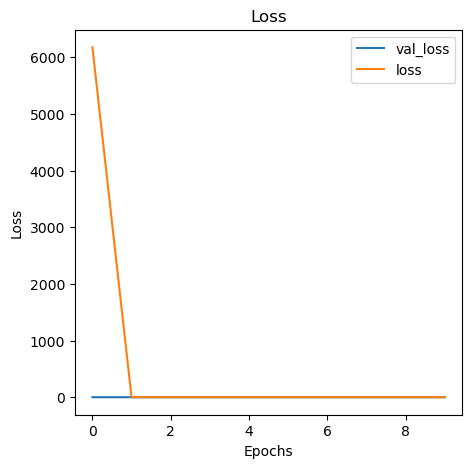

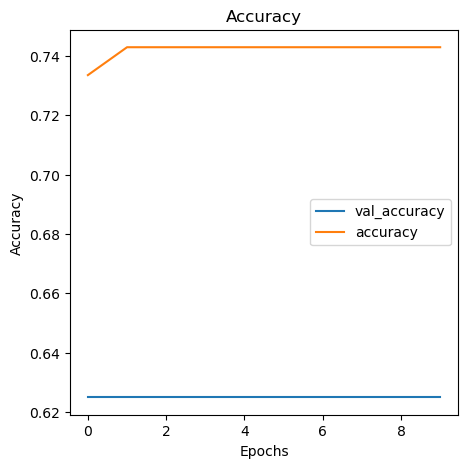

In [20]:
visualize_training_results(results_baseline)

Being that the loss and accuracy remained roughly the same for both sets over the course of our model, we can say that this isn't a great model. Our loss for the training set ended up being around .6, while it was around .75 for the validation set. Additionally, our accuracy for the training set remained around 75% while our accuracy for the validation set was only a mere 62.5%, which is on average barely better than random guessing.

## Building a bigger model

Let's create a new model with another hidden layer and tune some other parameters to see how our model improves

In [120]:
# Create the baseline model
model2 = Sequential()

#add first hidden layer, with 64 hidden units and activation of relu
model2.add(Dense(4096, activation='relu', input_shape=(12288,)))  

#second hidden layer with 32 units and relu activation
model2.add(Dense(2048, activation='relu'))   

# Output layer with 2 units for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model using adam
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 4096)              50335744  
                                                                 
 dense_50 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_51 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 58,728,449
Trainable params: 58,728,449
Non-trainable params: 0
_________________________________________________________________


In [121]:
# Fit the model to the training data, run 20 epochs and use a batch size of 64
results2 = model2.fit(train_img_unrow, train_labels_final, epochs=20, batch_size=64,
                    validation_data=(test_img_unrow, test_labels_final))

Epoch 1/20


2023-06-27 10:21:32.593556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - ETA: 0s - loss: 772.4191 - accuracy: 0.7421

2023-06-27 10:21:35.843747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 4s 39ms/step - loss: 772.4191 - accuracy: 0.7421 - val_loss: 14.9776 - val_accuracy: 0.8462
Epoch 2/20
82/82 [==============================] - 2s 29ms/step - loss: 17.2822 - accuracy: 0.8633 - val_loss: 135.3583 - val_accuracy: 0.6314
Epoch 3/20
82/82 [==============================] - 2s 30ms/step - loss: 5.2712 - accuracy: 0.9156 - val_loss: 24.1945 - val_accuracy: 0.6875
Epoch 4/20
82/82 [==============================] - 3s 30ms/step - loss: 1.8911 - accuracy: 0.9237 - val_loss: 5.9819 - val_accuracy: 0.8013
Epoch 5/20
82/82 [==============================] - 2s 30ms/step - loss: 1.7819 - accuracy: 0.9158 - val_loss: 3.6606 - val_accuracy: 0.7179
Epoch 6/20
82/82 [==============================] - 2s 29ms/step - loss: 4.7079 - accuracy: 0.8838 - val_loss: 3.7221 - val_accuracy: 0.7228
Epoch 7/20
82/82 [==============================] - 2s 30ms/step - loss: 0.7336 - accuracy: 0.9214 - val_loss: 3.5800 - val_accuracy: 0.7740
Epoch 8/20
82/82 

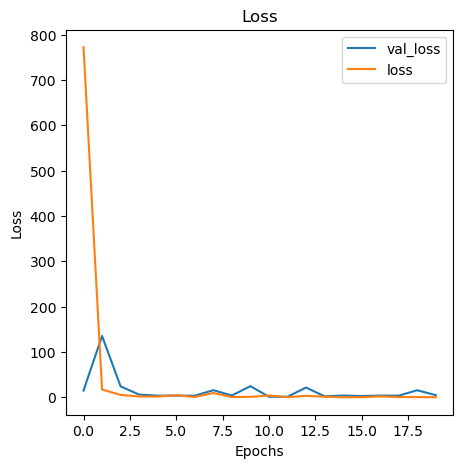

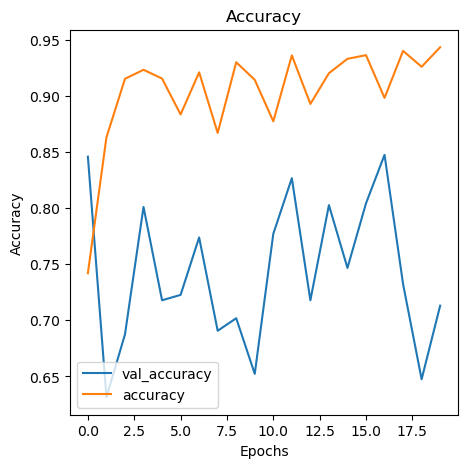

In [122]:
visualize_training_results(results2)

First off, there is a strong improvement in our accuracy for both the train and test set. At the same time we see that there definitely is overfitting as our training set had an accuracy of 96% while the test set had a mere 75%. We can also see that in terms of both loss and accuracy the model was improving and then becoming worse which is interesting to note. Let's move on and create a new model than can fix the issues with overfitting.

### Dropout model
We will use dropout to try to improve the issue of overfitting. Let's also tell the model to stop running if there is no improvement

In [24]:
# Define the callbacks, continue training for 5 epochs before stopping
early_stopping = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [27]:
# Create the model
dropout_model = Sequential()

#add Input layer, with 64 hidden units and activation of relu
dropout_model.add(Dense(64, activation='relu', input_shape=(12288,)))  
#add 20% dropout rate on the training set on input layer
dropout_model.add(Dropout(0.2))

#hidden layer with 32 units and relu activation
dropout_model.add(Dense(32, activation='relu'))   
#add 20% dropout rate on the first hidden layer
dropout_model.add(Dropout(0.2))

# Output layer with 2 units for binary classification
dropout_model.add(Dense(2, activation='sigmoid'))

# Compile the model using adam
dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
dropout_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                786496    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 2)                 66        
                                                                 
Total params: 788,642
Trainable params: 788,642
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Fit the model to the training data, run 20 epochs and use a batch size of 64
dropout_results = dropout_model.fit(train_img_unrow, train_labels, epochs=20, batch_size=64,
                      callbacks=early_stopping, validation_data=(test_img_unrow, test_labels))

Epoch 1/20


2023-06-27 10:00:20.619762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 2s 14ms/step - loss: 35.6987 - accuracy: 0.7404 - val_loss: 0.6871 - val_accuracy: 0.6234
Epoch 2/20
 1/82 [..............................] - ETA: 0s - loss: 0.6746 - accuracy: 0.7656

2023-06-27 10:00:21.813561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 10ms/step - loss: 2.6905 - accuracy: 0.7406 - val_loss: 0.6748 - val_accuracy: 0.6234
Epoch 3/20
82/82 [==============================] - 1s 10ms/step - loss: 0.6372 - accuracy: 0.7429 - val_loss: 0.6660 - val_accuracy: 0.6234
Epoch 4/20
82/82 [==============================] - 1s 10ms/step - loss: 0.6152 - accuracy: 0.7429 - val_loss: 0.6630 - val_accuracy: 0.6234
Epoch 5/20
82/82 [==============================] - 1s 10ms/step - loss: 0.6012 - accuracy: 0.7429 - val_loss: 0.6634 - val_accuracy: 0.6234
Epoch 6/20
82/82 [==============================] - 1s 10ms/step - loss: 0.5912 - accuracy: 0.7429 - val_loss: 0.6656 - val_accuracy: 0.6234
Epoch 7/20
82/82 [==============================] - 1s 10ms/step - loss: 0.5843 - accuracy: 0.7427 - val_loss: 0.6690 - val_accuracy: 0.6234
Epoch 8/20
82/82 [==============================] - 1s 10ms/step - loss: 0.5809 - accuracy: 0.7429 - val_loss: 0.6727 - val_accuracy: 0.6234
Epoch 9/20
82/82 [======

Clearly this was not a very good model at all. Let's try different techniques to improve our model. Let's try using L2 regularization to improve the model.

### L2 model

In [29]:
# Create the baseline model
L2_model = Sequential()

#add Input layer, with 64 hidden units and activation of relu
L2_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.005), 
                   input_shape=(12288,)))  

#hidden layer with 32 units and relu activation
L2_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(.005)))   


# Output layer with 2 units for binary classification
L2_model.add(Dense(2, activation='sigmoid'))

# Compile the model using adam
L2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
L2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                786496    
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 2)                 66        
                                                                 
Total params: 788,642
Trainable params: 788,642
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Fit the model to the training data, run 25 epochs and use a batch size of 64
L2_results = L2_model.fit(train_img_unrow, train_labels, epochs=25, batch_size=64,
                       validation_data=(test_img_unrow, test_labels))

Epoch 1/25


2023-06-27 10:00:29.028032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 2s 14ms/step - loss: 58.4827 - accuracy: 0.8144 - val_loss: 67.5844 - val_accuracy: 0.6667
Epoch 2/25


2023-06-27 10:00:30.209081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 10ms/step - loss: 12.6360 - accuracy: 0.9018 - val_loss: 17.6121 - val_accuracy: 0.8221
Epoch 3/25
82/82 [==============================] - 1s 10ms/step - loss: 6.4244 - accuracy: 0.9327 - val_loss: 94.9694 - val_accuracy: 0.6506
Epoch 4/25
82/82 [==============================] - 1s 11ms/step - loss: 8.4779 - accuracy: 0.9243 - val_loss: 63.8799 - val_accuracy: 0.7067
Epoch 5/25
82/82 [==============================] - 1s 10ms/step - loss: 8.2139 - accuracy: 0.9323 - val_loss: 106.0766 - val_accuracy: 0.6522
Epoch 6/25
82/82 [==============================] - 1s 10ms/step - loss: 11.5073 - accuracy: 0.9252 - val_loss: 34.9840 - val_accuracy: 0.7724
Epoch 7/25
82/82 [==============================] - 1s 10ms/step - loss: 5.6309 - accuracy: 0.9542 - val_loss: 37.2201 - val_accuracy: 0.7692
Epoch 8/25
82/82 [==============================] - 1s 11ms/step - loss: 8.9734 - accuracy: 0.9275 - val_loss: 70.1279 - val_accuracy: 0.7115
Epoch 9/25
82/

Again, it's unclear if this model was better than our second model, because although the training values increased, the testing set values fluctuated a lot, between the high 60s and low 80s. Additionally, a similar affect occurs when tested with L1 regularizer

In [123]:
# Create the baseline model
he_model = Sequential()

#add Input layer, with 64 hidden units and activation of relu
he_model.add(Dense(4096, activation='relu', kernel_initializer='he_normal', 
                   input_shape=(12288,)))  

#hidden layer with 32 units and relu activation
he_model.add(Dense(2048, activation='relu'))   

#hidden layer with 32 units and relu activation
he_model.add(Dense(1024, activation='relu')) 

# Output layer with 2 units for binary classification
he_model.add(Dense(1, activation='sigmoid'))

# Compile the model using adam
he_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
he_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 4096)              50335744  
                                                                 
 dense_53 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_54 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_55 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 60,825,601
Trainable params: 60,825,601
Non-trainable params: 0
_________________________________________________________________


In [124]:
# Fit the model to the training data, run 25 epochs and use a batch size of 64
he_results = he_model.fit(train_img_unrow, train_labels_final, epochs=50, batch_size=64, 
                          callbacks=early_stopping,
                       validation_data=(test_img_unrow, test_labels_final))

Epoch 1/50


2023-06-27 10:24:16.632205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - ETA: 0s - loss: 690.7960 - accuracy: 0.7080

2023-06-27 10:24:19.835093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 4s 38ms/step - loss: 690.7960 - accuracy: 0.7080 - val_loss: 11.7466 - val_accuracy: 0.6667
Epoch 2/50
82/82 [==============================] - 2s 30ms/step - loss: 2.6439 - accuracy: 0.8451 - val_loss: 2.5884 - val_accuracy: 0.7885
Epoch 3/50
82/82 [==============================] - 2s 30ms/step - loss: 0.6645 - accuracy: 0.9074 - val_loss: 6.7700 - val_accuracy: 0.6554
Epoch 4/50
82/82 [==============================] - 2s 30ms/step - loss: 1.1915 - accuracy: 0.8871 - val_loss: 4.0937 - val_accuracy: 0.6875
Epoch 5/50
82/82 [==============================] - 2s 30ms/step - loss: 1.9097 - accuracy: 0.8972 - val_loss: 7.4920 - val_accuracy: 0.6859
Epoch 6/50
82/82 [==============================] - 2s 30ms/step - loss: 1.0250 - accuracy: 0.9057 - val_loss: 2.7540 - val_accuracy: 0.6811
Epoch 7/50
82/82 [==============================] - 2s 30ms/step - loss: 0.6666 - accuracy: 0.9082 - val_loss: 8.1354 - val_accuracy: 0.6731


Again, we are not getting any better accuracy on our test set. Additionally, I tried the same thing with Lecun Initializer and the same thing occured

### CNN

In [33]:
#lets pull up the shape of the data again
print('Train Images:', np.shape(train_images))
print('Train Labels:',np.shape(train_labels))
print('Test Images:',np.shape(test_images))
print('Test Labels:',np.shape(test_labels))
print('Val Images:',np.shape(val_images))
print('Val Labels:',np.shape(val_labels))

Train Images: (5216, 64, 64, 3)
Train Labels: (5216, 2)
Test Images: (624, 64, 64, 3)
Test Labels: (624, 2)
Val Images: (16, 64, 64, 3)
Val Labels: (16, 2)


In [34]:
#Normalize pixel values to between 0 and 1
train_images, test_images, val_images = train_images/255, test_images/255, val_images/255

In [125]:
conv_model = Sequential()

In [127]:
conv_model.add(Conv2D (256, (3, 3), activation='tanh', input_shape= (64, 64, 3))) 
conv_model.add(MaxPooling2D( (2, 2))) 
conv_model.add(Conv2D(512, (3, 3), activation='tanh')) 
conv_model.add(MaxPooling2D( (2, 2))) 
conv_model.add(Conv2D(1024, (3, 3), activation='tanh'))

In [128]:
conv_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 512)       1180160   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 512)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 1024)      4719616   
                                                                 
Total params: 5,906,944
Trainable params: 5,906,944
N

In [130]:
conv_model.add(Flatten())
conv_model.add(Dense(64, activation='tanh' )) 
conv_model.add(Dense(1, activation='sigmoid'))

In [131]:
conv_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 512)       1180160   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 512)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 1024)      4719616   
                                                                 
 flatten (Flatten)           (None, 147456)          

In [132]:
conv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [137]:
conv_model.fit(train_images, train_labels_final, epochs=10, batch_size=1000)

Epoch 1/10


TypeError: 'NoneType' object is not callable

In [ ]:
test_loss, test_acc = model.evaluate (test_images, test_labels)